# Comparing architectures

The aim of this practical is to use a new synthetic dataset: percolations through a rectangle, explained below. 

The advantage of using this dataset is that the inputs are small, so that the neural nets can be small but deep, and it is possible for you to compare many different net designs quickly, training only with a cpu. 

But the concept of percolation is 'deep': there is no simple logical description of when there is a percolating path across a rectangle. Logistic regression fails completely.  There are many paths from one side of the square to the other, and the neural network needs to be able to recognise all of them. The function required to do this is highly non-linear, and there are dependencies between more than 8 values in a 8x8 square. 

Ironically, there is a simple iterative Python function that easily computes whether a matrix percolates, using depth first search. This is very quick, uses little computation, and it is 100% accurate.  


Percolation is not an easy property for neural nets to recognise. Nobody has yet managed to design a neural net that gets 100% accuracy !! Even after 30,000 training examples...   I challenge you to try ! 

# Percolation data

To define some image data, we will consider small images, initially of size 8x8 in black and white (or 0 and 1). 

The first concept that we will try to teach a NN is whether there is a continuous path of "white" pixels between the two sides of the image.

The function `percolate` returns True is there is a continuous path between the left and right sides of a binary image. (Aspects of python that are used are sets, a while loop, and break. )  

In [35]:
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [36]:
from random import randint

In [37]:
# this function does a depth-first search across a matrix of 0s and 1s, 
# looking for a path of 1s between the first and last columns of the matrix
# such a path is called a 'percolation path'

def percolate( mat ):
    """
    Returns True if there is a percolation path of 1s from col 0 col -1 of a matrix of 0s and 1s
    """
    nrows = mat.shape[0]
    ncols = mat.shape[1]
    frontier = set()
    for i in range(0,nrows):
        if mat[i,0]:
            frontier.add( (i,0) )
    explored = set()
    flag = False # this will be returned if the frontier becomes empty without finding a
                 # filled pixel in the right-most column
    while frontier: # frontier evaluates to True in this context if it is non-empty
        r,c = frontier.pop()
        explored.add( (r,c) )
        if r > 0: # North
            if mat[r-1,c]:
                coords = (r-1,c)
                if coords not in explored: 
                    if coords not in frontier: # this order of testing is necessary since each element of explored has been in frontier
                        frontier.add( coords )
        if c < ncols-1: # East
            if mat[r,c+1]:
                if c+1 == mat.shape[1]-1 : # Hurray, we have percolated to the last column
                    flag = True
                    break
                coords = (r,c+1)
                if coords not in explored: 
                    if coords not in frontier: # this order of testing is necessary since each element of explored has been in frontier
                        frontier.add( coords )
        if r < nrows-1: # South
            if mat[r+1,c]:
                coords = (r+1,c)
                if coords not in explored: 
                    if coords not in frontier: # this order of testing is necessary since each element of explored has been in frontier
                        frontier.add( coords )
        if c > 0: # West
            if mat[r,c-1]:
                coords = (r,c-1)
                if coords not in explored: 
                    if coords not in frontier: # this order of testing is necessary since each element of explored has been in frontier
                        frontier.add( coords )
    return flag
        

Now test the percolate function. We will generate random images with a probability 0.6 probability of 1 in each pixel. 

In [ ]:
tmp = np.random.random([8,8]) > 0.4

plt.imshow(tmp), percolate(tmp)

# the first result is an image; the second result is True if there is a continuous path of yellow squares from the left to
# the right side of the image. The path is continuous if the yellow squares are joined at one side: two yellow squares 
# at a corner do not count as joined in a path

# you can evaluate this cell many times, and each time look at the resulting plot and answer, to check that you 
# understand the notion of percolation, and also that the `percolate` function is getting it right ! 

In [39]:
# How many 8x8 binary patterns are there? 

2.0**64

1.8446744073709552e+19

More than 18 billion, so our NN will need to generalise, because we will give it training sets of far fewer than 18 billion examples. 

# Construct datasets 

The joy of synthetic data is that we can construct as much of it as we want...

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F  # this includes tensor functions that we can use in backwards pass
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
import torch.optim as optim

In [41]:
def make_percolation_dataset(side=8,threshold=0.42,n_examples=10):
    """
    This function generates an array of random images, in the form needed for Keras, and 
    then labels them as percolati# ng or not, using the percolate function. Roughly 50% of the
    images will have class 1 (percolating), so the dataset is likely to be reasonably balanced. 
    """
    X_data = (np.random.random([n_examples,side,side,1]) > threshold).astype(float) 
    Y_data = np.zeros([n_examples,1])
    for i in range(0,n_examples):
        if percolate(X_data[i,:,:,0]):
            Y_data[i,0] = 1
    return [(torch.tensor(x.astype(np.float32)).reshape(1,8,8), torch.tensor(float(y)).reshape(1) )  for x,y in zip( X_data, Y_data)]

# the types of the numbers in the tensors need to be float32: the most natural place to do this data conversion
# is in generating the datasets. 

In [42]:
training_set = make_percolation_dataset( n_examples = 1000 )
test_set = make_percolation_dataset( n_examples = 1000 )

C:\Users\papap\AppData\Local\Temp\ipykernel_13688\2932291848.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [(torch.tensor(x.astype(np.float32)).reshape(1,8,8), torch.tensor(float(y)).reshape(1) )  for x,y in zip( X_data, Y_data)]


When we make a dataset, we should always check how many there are of each class:  

In [43]:
# this calculates the fraction of positive examples in the training set
sum( [ x[1].item() for x in training_set ] ) / len( training_set)

0.461

The fraction of positive examples should ideally be close to 0.5  -- the default probability that a pixel is equal to 1 was chosen to ensure this. 

In [ ]:
# check that a random element of the training set is correctly labelled
x,y = training_set[376]
plt.imshow(x.numpy().squeeze() ), y  # check a random element of the training set to see it is correct
# we need to squeeze the 

If there is a continuous yellow path from the left side to the right side of the image, then the image "percolates" and the y value should be 1, otherwise the y value should be 0. 

# Constructing and training models

### A naive fully connected  Dense model for detecting percolation

(For tutorial purposes) the first thing to try is a naive model which pays no attention to the image structure. I don't expect this type of model to work well - but you may find a way to surprise me. 

In the model defined below, we flatten the image to a single row of values, and then we put in a single layer of neurons, each one of which is connected to all of the inputs. In other words, each neuron in this layer has 64 inputs, and then there is a final neuron which gives the output. 

You will (I hope) find that this is a terrible architecture for this problem. You will find that if there are too few neurons, then the model cannot even fit the training data.  If there are too many neurons in the Dense layer, then the model will fit the training data, but fail almost completely on the validation data: that is, the model will overfit badly. 

What would be the only way to get this poorly designed model to work? *Use a lot of training data!* . You can try constructing a much larger training set, and then see if you can get this model to classify correctly.  I doubt it - but you might succeed. 

Does adding more dense layers help?  Does adding regularisation - either `l1`, `l2`, or dropout - help? 

In [45]:
# our simplest neural net - it is just going to be a linear layer and then sigmoid 
# (equivalent to softmax when there are only two classes)
# This is simply logistic regression. We expect it to do badly on validation data, but it 
# may overfit  training data
class NN1( nn.Module ):
    
    def __init__(self): 
        super(NN1, self).__init__()
        self.layers = nn.Sequential( 
            nn.Flatten(), 
            nn.Linear(64,1),
            nn.Sigmoid())  # a linear layer (a matrix, plus biases) with 784 inputs and 10 outputs
             # if we are going to make probabilistic categorical predictions, it is more flexible to allow unnormalised 
             # outputs, because we can use  different functions for the predictions and and in calculating the loss, as 
             # we shall soon see
    
    
    def forward( self, x ): # computes the forward pass ... this one is particularly simple
        x = self.layers( x )
        return x

In [46]:
net = NN1() 
# the first time I coded this, I thought nn would be a good name for the network,
# but unfortunately it masks the PyTorch nn module .... so I am using net instead

In [47]:
net.layers

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=64, out_features=1, bias=True)
  (2): Sigmoid()
)

In [ ]:
# the state_dict is a useful attribute of a Model, 
# which contains convenient names as keys for all the tensors
net.state_dict()

Now we will go step by step through all the stages of constructing a NN training loop, before putting it all together.

In [49]:
# DataLoader is a useful utility class provided by pytorch for extracting minibatches from 
# a large dataset. 

trainloader = torch.utils.data.DataLoader( training_set, batch_size=4, shuffle=True)
testloader = torch.utils.data.DataLoader( test_set, batch_size=4, shuffle=True)

# if you want to change the batch size, you need to define a new dataloader: 
# the dataloader is a lightweight class that just provides iteration over the dataset

In [50]:
# we construct a (temporary) iterator from trainloader, and we get the first minibatch
tmpiter = iter(trainloader)

images, labels = next(tmpiter) # the minibatch is a list of [ images, labels ]

# let's check what form the images and labels come in

In [ ]:
labels

In [52]:
images.shape # always check the shapes of your tensors...

torch.Size([4, 1, 8, 8])

In [ ]:
net.forward( images ) # does our nn work? What does it produce? 

### Which loss function? 

We will use log-loss, because we are predicting classes (0 and 1, non-percolating and percolating).  

We could use two outputs, produced by softmax, and cross-entropy loss, as we did for MNIST. 

But then we have highly redundant output weights: this may (I am not sure) 

We can equivalently use one sigmoid neuron as output: the output of this neuron is the predicted probability of 1. 

The loss function is provided by PyTorch: BCELoss.  Look at its documentation on the PyTorch site. 

In [54]:
# BCELoss is binary cross entropy loss: 
# this takes a single probability (as output by a sigmoid neuron for example)
loss_function = nn.BCELoss() 

# note that the result of loss function is a one element tensor: it needs to be 
# tensor because we start the backward pass from the loss. 

In [55]:
loss_function( net.forward( images ), labels )

tensor(0.7629, grad_fn=<BinaryCrossEntropyBackward0>)

-Log( 0.5 ) = 0.69, so we expect the average loss to be 0.7ish, as the network is not trained yet. 

### Calculating Accuracy

How do we calculate accuracy, which is the percentage of correct predictions? 

We cound a sigmoid output that is > 0.5 as predicting a 1, and if it is < 0.5, as a prediction of 0. 

In [ ]:
result = net.forward(images)
result

In [ ]:
result > 0.5

In [ ]:
labels > 0.5 

In [59]:
# This expression gives the sum of the number of correct predictions in the batch
# Note that we access the value of a zero-dimensional tensor with .item()

sum( (result > 0.5) == (labels > 0.5 ) ).item()

2

In [60]:
# this function calculates the loss and error rate on the validation set
# assuming that the output of the neural net nn is a single prediction probability, from a single sigmoid neuron. 

def accuracy_and_loss( net, loss_function, dataloader ):
    total_correct = 0 
    total_loss = 0.0 
    total_examples = 0 
    n_batches = 0 
    with torch.no_grad():  # we do not neet to compute the gradients when making predictions on the validation set
        for data in dataloader: 
            images, labels = data
            outputs = net(images)
            batch_loss = loss_function(outputs, labels) # this is averaged over the batch
            n_batches += 1
            total_loss += batch_loss.item()
            total_correct += sum( (outputs > 0.5 ) == ( labels > 0.5 ) ).item() # number correct in the minibatch
            total_examples += labels.size(0) # the number of labels, which is just the size of the minibatch 
             
    
    accuracy = total_correct / total_examples
    mean_loss = total_loss / n_batches

    error_rate= 1 - accuracy

    
    
    return ( accuracy, mean_loss, error_rate)
    #print( "Accuracy on test set: %d %%" %(100 * correct/total_examples))


In [61]:
# Testing accuracy_and_loss

accuracy_and_loss( net, loss_function, testloader)

(0.48, 0.708239634513855, 0.52)

Accuracy should be 0.5ish, loss should be 0.7ish

## Putting it all together: training a network

In [ ]:
# This cell is our pattern for nn initialisation and training 
# In the next section we convert it into a function...

trainloader = torch.utils.data.DataLoader( training_set, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader( test_set, batch_size=32, shuffle=True)

net = NN1()
optimizer1 = optim.RMSprop( net.parameters(), lr=0.001 )

for epoch in range(200): # number of times to loop over the dataset
    total_loss = 0 
    total_correct = 0 
    total_examples = 0 
    n_mini_batches = 0
    
    for i, mini_batch in enumerate( trainloader, 0 ):
        images, labels = mini_batch
        
        # zero the parameter gradients
        # all the parameters that are being updated are in the optimizer, 
        # so if we zero the gradients of all the tensors in the optimizer, 
        # that is the safest way to zero all the gradients
        optimizer1.zero_grad()
        
        outputs = net(images) # this is the forward pass
        
        loss = loss_function ( outputs, labels )
        
        loss.backward() # does the backward pass and computes all gradients
        
        optimizer1.step() # does one optimisation step
        
        n_mini_batches += 1 # keep track of number of minibatches, and collect the loss for each minibatch
        total_loss += loss.item() # remember that the loss is a zero-order tensor
        # so that to extract its value, we use .item(), as we cannot index as there are no dimensions
        
        # keep track of number of examples, and collect number correct in each minibatch
        total_correct += sum( ( outputs > 0.5 ) == ( labels > 0.5 ) ).item()
        total_examples += len( labels )
        
    # calculate statistics for each epoch and print them. 
    # You can alter this code to accumulate these statistics into lists/vectors and plot them
    epoch_training_accuracy = total_correct / total_examples
    epoch_training_loss = total_loss / n_mini_batches
    
    val_accuracy, val_loss, val_error_rate = accuracy_and_loss( net, loss_function, testloader )
    
    print('Epoch %d loss: %.3f acc: %.3f val_loss: %.3f val_acc: %.3f val_error_rate: %.3f'
          %(epoch+1, epoch_training_loss, epoch_training_accuracy, val_loss, val_accuracy,  val_error_rate  ))
            



As we might expect, logistic regression does not work well in identifying percolation. The concept is too complicated. We need a more complex network. 

From now on it is up to you to design a range of network architectures, and see how well they do on this apparently simple problem. 

You can try numbers of hidden units ranging from 10 to 1000; you can try multiple layers (but with less than 100 neurons per layer - connecting a layer with 1000 neurons to another with 1000 neurons needs a million weights, which is too many for the CPU to handle in a reasonable time.)

When you define a larger model, start off with a small number of epochs - 2,say! you can then figure out how long a longer training will take. 

See below for how to examine the structure of the history, and to plot curves of loss and accuracy during training for both the training and validation data. 

In [63]:
# a nn with one hidden layer
class NN_one_hidden( nn.Module ):
    
    def __init__(self): 
        super(NN_one_hidden, self).__init__()
        self.layers = nn.Sequential( 
            nn.Flatten(), 
            nn.Linear(64,100), # try 100 hidden neurons
            nn.ReLU(),      # note that we need the brackets after nn.ReLU() and nn.Sigmoid(), because these 
                            # are classes that need to be instantiated
            nn.Linear(100,1),
            nn.Sigmoid())  # we are predicting only two classes, so we can use one sigmoid neuron as output
    
    def forward( self, x ): # computes the forward pass ... this one is particularly simple
        x = self.layers( x )
        return x

In [64]:
cc = NN_one_hidden()
cc

NN_one_hidden(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

In [65]:
class NN_two_hidden( nn.Module ):
    
    def __init__(self): 
        super(NN_two_hidden, self).__init__()
        self.layers = nn.Sequential( 
            nn.Flatten(), 
            nn.Linear(64,100), # try 100 hidden neurons
            nn.ReLU(),      # note that we need the brackets after nn.ReLU() and nn.Sigmoid(), because these 
                            # are classes that need to be instantiated
            nn.Linear(100,100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid())  # we are predicting only two classes, so we can use one sigmoid neuron as output
    
    def forward( self, x ): # computes the forward pass ... this one is particularly simple
        x = self.layers( x )
        return x

You will be defining many NN architectures (hopefully) so here is an encapsulation of the NN training cycle in a function. 

Experienced Python programmers may do it better than this...

In [70]:
# this function takes a neural-net class as argument, 
# together with the number of epochs, datasets, and batch-size
# I have written it like this to make sure you remember to initialise a new NN 
# (However you can redefine it to take a pre-initialised NN, so that you can repeatedly 
# train a NN with the same weights, as often as you want. )

def define_and_train( NN_class, n_epochs, training_set, test_set, batch_size=32, weight_decay=0.0 ):
    
    trainloader = torch.utils.data.DataLoader( training_set, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader( test_set, batch_size=batch_size, shuffle=True)

    thenet = NN_class()
    optimizer1 = optim.Adam( thenet.parameters(), weight_decay=weight_decay )
    
    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []
    
    for epoch in range(n_epochs): # number of times to loop over the dataset
        
        total_loss = 0 
        total_correct = 0 
        total_examples = 0 
        n_mini_batches = 0
    
        for i, mini_batch in enumerate( trainloader, 0 ):
            images, labels = mini_batch

            # zero the parameter gradients
            # all the parameters that are being updated are in the optimizer, 
            # so if we zero the gradients of all the tensors in the optimizer, 
            # that is the safest way to zero all the gradients
            optimizer1.zero_grad()

            outputs = thenet(images) # this is the forward pass

            loss = loss_function ( outputs, labels )

            loss.backward() # does the backward pass and computes all gradients

            optimizer1.step() # does one optimisation step

            n_mini_batches += 1 # keep track of number of minibatches, and collect the loss for each minibatch
            total_loss += loss.item() # remember that the loss is a zero-order tensor
            # so that to extract its value, we use .item(), as we cannot index as there are no dimensions

            # keep track of number of examples, and collect number correct in each minibatch
            total_correct += sum( ( outputs > 0.5 ) == ( labels > 0.5 ) ).item()
            total_examples += len( labels )

        # calculate statistics for each epoch and print them. 
        # You can alter this code to accumulate these statistics into lists/vectors and plot them
        epoch_training_accuracy = total_correct / total_examples
        epoch_training_loss = total_loss / n_mini_batches

        epoch_val_accuracy, epoch_val_loss, val_error_rate = accuracy_and_loss( thenet, loss_function, testloader )

        print('Epoch %d loss: %.3f acc: %.3f val_loss: %.3f val_acc: %.3f'
              %(epoch+1, epoch_training_loss, epoch_training_accuracy, epoch_val_loss, epoch_val_accuracy   ))
        
        train_loss.append( epoch_training_loss )
        train_acc.append( epoch_training_accuracy )
        val_loss.append( epoch_val_loss )
        val_acc.append( epoch_val_accuracy )
    
    history = { 'train_loss': train_loss, 
                'train_acc': train_acc, 
                'val_loss': val_loss,
                'val_acc': val_acc }
    return ( history, thenet ) 


In [71]:
big_training_set = make_percolation_dataset( n_examples=10000 )

C:\Users\papap\AppData\Local\Temp\ipykernel_13688\2932291848.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [(torch.tensor(x.astype(np.float32)).reshape(1,8,8), torch.tensor(float(y)).reshape(1) )  for x,y in zip( X_data, Y_data)]


In [ ]:
history1, net1 = define_and_train( NN_one_hidden, 50, training_set, test_set, batch_size=32, weight_decay=0.0000 )

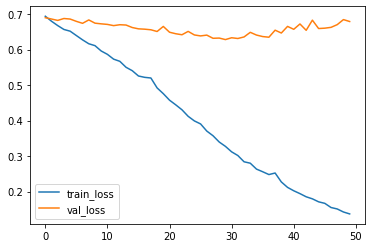

In [ ]:
plt.plot( history1['train_loss'], label='train_loss')
plt.plot( history1['val_loss'], label='val_loss')
plt.legend()

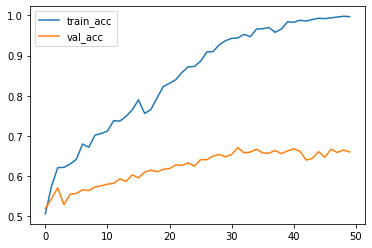

In [ ]:
plt.plot( history1['train_acc'], label='train_acc')
plt.plot( history1['val_acc'], label='val_acc')
plt.legend()

In [ ]:
history2, net2 = define_and_train( NN_two_hidden, 50, training_set, test_set, batch_size=32, weight_decay=0.0000 )

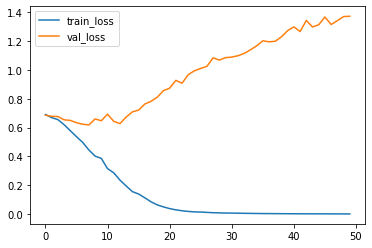

In [ ]:
plt.plot( history2['train_loss'], label='train_loss')
plt.plot( history2['val_loss'], label='val_loss')
plt.legend()

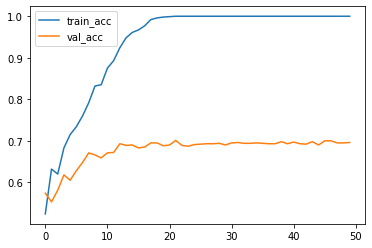

In [ ]:
plt.plot( history2['train_acc'], label='train_acc')
plt.plot( history2['val_acc'], label='val_acc')
plt.legend()

### A convolutional model for detecting percolation

Since percolation depends on local properties of the image, a better strategy may be to used a convolutional model, like the one defined below. 

After some messing about, I found that the model defined has reasonable (but not perfect) performance.  Please try to find a better one ! I was a little disappointed that I found that max-pooling layers seemed to slightly reduce performance, but you might find differently.  

Perhaps some 1x1 convolutions might improve performance?  I haven't tried them. 

Your challenge is to try this model out, and then to do some experiments. (To do experiments, you will need to be tidy: I suggest  

* For a small training set size (say 1000) examine the effect of different types and levels of regularisation. Try putting in `l1` and `l2` regularisation, and dropout (try each separately). 
    When adding `l1` or `l2` regularisation, a reasonable amount to add is in the region of 
    0.00001 to 0.001 .  Larger amounts of regularisation will just force all the weights towards zero. 

* How does validation error vary with training set size?  This is an important question!  Plot  log validation error versus  log training set size, in the range from 100 to 32000 (or 100000 if you have the time)  Plot a log-log graph, and see if you can identify a power law, visible as a straight(ish) line on the graph.  



### Constructing a convolutional model in Pytorch

We need to keep track of the sizes of the tensors as we build a convolutional net.

One easy way to do this is to evaluate part of the network, using zeros as inputs, and look at the shape of the resulting tensor. 

In [1]:
nn.Sequential( 
            nn.Conv2d(1,12,3,padding=1),
            nn.ReLU(), 
            nn.Conv2d(12,12,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(12,2,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU() )( torch.zeros(1,1,8,8) ).shape

NameError: name 'nn' is not defined

In [ ]:
nn.Sequential( nn.Conv2d(1,12,3,padding=1), nn.ReLU() )( torch.zeros(1,1,8,8)).shape

torch.Size([1, 12, 8, 8])

In [ ]:
class NN_convolutional1( nn.Module ):
    
    def __init__(self): 
        super(NN_convolutional1, self).__init__()
        self.layers = nn.Sequential( 
            nn.Conv2d(1,12,3,padding=1),
            nn.ReLU(), 
            nn.Conv2d(12,12,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(12,2,3,padding=1), # idea: hopefully these will be connected to left edge, connected to right edge
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128,12), # the 128 here is the number of elements in the tensor computed so far
            nn.ReLU(), 
            nn.Linear(12,1),
            nn.Sigmoid())  # we are predicting only two classes, so we can use one sigmoid neuron as output
    
    def forward( self, x ): # computes the forward pass ... this one is particularly simple
        x = self.layers( x )
        return x

In [ ]:
print( NN_convolutional1() )

In [ ]:
history3, net = define_and_train( NN_convolutional1, 50, training_set, test_set, batch_size=32, weight_decay=0.0000 )

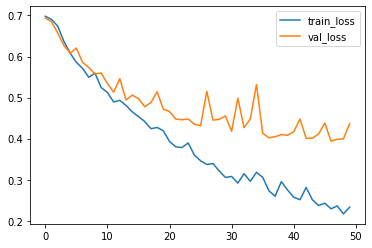

In [ ]:
plt.plot( history3['train_loss'], label='train_loss')
plt.plot( history3['val_loss'], label='val_loss')
plt.legend()

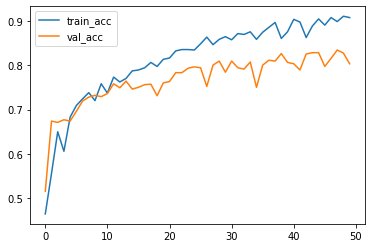

In [ ]:
plt.plot( history3['train_acc'], label='train_acc')
plt.plot( history3['val_acc'], label='val_acc')
plt.legend()

# The Golden Rules of Model Search

Step 1: what error rate do you expect a good model to have?  (It may be zero, or there may be some residual error rate - perhaps even humans do not perform perfectly.) Call this error rate the *ideal error rate*

Step 2: define and fit a model and examine the training and validation errors. 

Step 3a: If the model does not fit the training set well, then the model does not have enough capacity (flexibility).  Add more complexity in some way  - more neurons, more layers. It is of course best to do this in an insightful way !  Go to step 2. 

Step 3b: If the model *does* fit the training set well, but there is higher error on the validation set, then the model is overfitted. Do either (or both)  of: 

    * Use more training data
    
    * Add more regularisation to the model (in an insightful way). 
    
Go to step 2. 


These golden rules are not very specific, but they are a lot better than simply making random changes to the model and hoping that it gets better. 



### Power law for convolutional model 

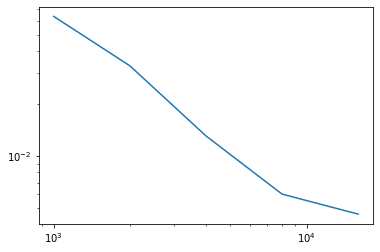

In [ ]:
# actually plot the training set size vs validation error
# these are actual error-rates with a previous (more complex) convolutional model
plt.loglog([1000,2000,4000,8000,16000], [0.0636,0.0330,0.0130,0.006,0.0046])

# Inspection of errors

 Exercise: find the errors on the training and validation sets, and inspect them.
 
 Can you say anything useful about what your net is doing wrong? 

 I found that the false-negatives -- the percolating examples that the net thought did not percolate -- tended to have long percolating paths, as one might expect. 
 
 But I could not see any regularities in the false-positive -- the non-percolating examples that the net thought would percolate -- at all. 

# Test examples for percolation


This is a test-set of some specially constructed examples that are designed to be 'corner cases' on which to test your network. 

In [ ]:
test_all_zeros = np.zeros([8,8])
plt.imshow(test_all_zeros)
plt.colorbar()

In [ ]:
test_all_ones = np.ones([8,8])
plt.imshow(test_all_ones)
plt.colorbar()

In [ ]:
test_eye = np.eye(8) # this should be an easy example
plt.imshow(test_eye)
plt.colorbar()

In [ ]:
test_inverse_eye = 1 - np.eye(8)
plt.imshow( test_inverse_eye )

In [ ]:
test_inverse_eye_connected = 1 - np.eye(8)
test_inverse_eye_connected[4,4] = 1
plt.imshow( test_inverse_eye_connected )

In [ ]:
test_inverse_eye_connected_bottom = 1 - np.eye(8)
test_inverse_eye_connected_bottom[7,7] = 1
plt.imshow( test_inverse_eye_connected_bottom )

In [ ]:
test_inverse_eye_connected_top = 1 - np.eye(8)
test_inverse_eye_connected_top[0,0] = 1
plt.imshow( test_inverse_eye_connected_top )

In [ ]:
test_middle_row = np.zeros([8,8])
test_middle_row[3,:] = 1
plt.imshow(test_middle_row)

In [ ]:
test_top_row = np.zeros([8,8])
test_top_row[0,:] = 1
plt.imshow(test_top_row)

In [ ]:
test_bottom_row = np.zeros([8,8])
test_bottom_row[-1,:] = 1
plt.imshow(test_bottom_row)

In [ ]:
test_vertical_column_disconnect = np.ones([8,8])
test_vertical_column_disconnect[:,4] = 0 
plt.imshow(test_vertical_column_disconnect)

In [ ]:
test_row_with_gap = np.zeros([8,8])
test_row_with_gap[3,:] = 1
test_row_with_gap[3,4] = 0 
plt.imshow(test_row_with_gap)

In [ ]:
test_two_rows_nearly = np.zeros([8,8])
test_two_rows_nearly[2,:7] = 1
test_two_rows_nearly[4,1:] = 1
plt.imshow(test_two_rows_nearly)

In [ ]:
test_four_rows_nearly = np.zeros([8,8])
test_four_rows_nearly[0,:7] = 1
test_four_rows_nearly[2,1:] = 1
test_four_rows_nearly[4,:7] = 1
test_four_rows_nearly[6,1:] = 1
plt.imshow(test_four_rows_nearly)

In [ ]:
test_dog_leg = np.zeros([8,8])
test_dog_leg[1,:5] = 1
test_dog_leg[2:7,4] = 1
test_dog_leg[6,4:] = 1
plt.imshow(test_dog_leg)

In [ ]:
test_dog_leg_back = np.zeros([8,8])
test_dog_leg_back[1,:5] = 1
test_dog_leg_back[2:5,4] = 1
test_dog_leg_back[4:6,3] = 1
test_dog_leg_back[6,3:] = 1
plt.imshow(test_dog_leg_back)

In [ ]:
test_long_path = np.zeros([8,8])
test_long_path[1,:7] = 1
test_long_path[2:4,6] = 1
test_long_path[4,1:7] = 1
test_long_path[5:7,1] = 1
test_long_path[6,1:] = 1
plt.imshow(test_long_path)


In [ ]:
test_longer_path = np.zeros([8,8])
test_longer_path[0,:7] = 1
test_longer_path[1:3,6] = 1
test_longer_path[2,1:7] = 1
test_longer_path[3:8,1] = 1
test_longer_path[7,2:4] = 1
test_longer_path[4:7,3] = 1
test_longer_path[4,4:6] = 1
test_longer_path[5:8,5] = 1
test_longer_path[7,6:8] = 1
plt.imshow(test_longer_path)

In [ ]:
test_vertical_stripes = np.zeros([8,8])
test_vertical_stripes[:,1] = 1
test_vertical_stripes[:,3] = 1
test_vertical_stripes[:,5] = 1
test_vertical_stripes[:,7] = 1
plt.imshow(test_vertical_stripes)

In [ ]:
test_vertical_stripes_connected_1 = np.zeros([8,8])
test_vertical_stripes_connected_1[:,1] = 1
test_vertical_stripes_connected_1[:,3] = 1
test_vertical_stripes_connected_1[:,5] = 1
test_vertical_stripes_connected_1[:,7] = 1
test_vertical_stripes_connected_1[7,0] = 1
test_vertical_stripes_connected_1[0,2] = 1
test_vertical_stripes_connected_1[7,4] = 1
test_vertical_stripes_connected_1[0,6] = 1

plt.imshow(test_vertical_stripes_connected_1)

In [ ]:
test_vertical_stripes_connected_2 = np.zeros([8,8])
test_vertical_stripes_connected_2[:,1] = 1
test_vertical_stripes_connected_2[:,3] = 1
test_vertical_stripes_connected_2[:,5] = 1
test_vertical_stripes_connected_2[:,7] = 1
test_vertical_stripes_connected_2[6,0] = 1
test_vertical_stripes_connected_2[1,2] = 1
test_vertical_stripes_connected_2[6,4] = 1
test_vertical_stripes_connected_2[1,6] = 1

plt.imshow(test_vertical_stripes_connected_2)

In [ ]:
test_vertical_stripes_disconnected_1 = np.zeros([8,8])
test_vertical_stripes_disconnected_1[:,1] = 1
test_vertical_stripes_disconnected_1[:,3] = 1
test_vertical_stripes_disconnected_1[:,5] = 1
test_vertical_stripes_disconnected_1[:,7] = 1
test_vertical_stripes_disconnected_1[6,0] = 1
test_vertical_stripes_disconnected_1[1,2] = 1
test_vertical_stripes_disconnected_1[6,2] = 1
test_vertical_stripes_disconnected_1[1,6] = 1

plt.imshow(test_vertical_stripes_disconnected_1)

In [ ]:
test_vertical_stripes_connected_3 = np.zeros([8,8])
test_vertical_stripes_connected_3[:,1] = 1
test_vertical_stripes_connected_3[:,3] = 1
test_vertical_stripes_connected_3[:,5] = 1
test_vertical_stripes_connected_3[:,7] = 1
test_vertical_stripes_connected_3[4,:] = 1

plt.imshow(test_vertical_stripes_connected_3)

In [ ]:
test_examples = [test_all_ones,
                 test_eye, 
                 test_inverse_eye,
                 test_inverse_eye_connected,
                 test_inverse_eye_connected_bottom,
                 test_inverse_eye_connected_top,
                 test_middle_row, test_top_row, 
                 test_bottom_row, 
                 test_vertical_column_disconnect,
                 test_row_with_gap, 
                 test_two_rows_nearly, 
                 test_four_rows_nearly, 
                 test_dog_leg, 
                 test_dog_leg_back,
                 test_long_path, 
                 test_longer_path, 
                 test_vertical_stripes,
                 test_vertical_stripes_connected_1,
                 test_vertical_stripes_connected_2,
                 test_vertical_stripes_connected_3,
                 test_vertical_stripes_disconnected_1]

In [ ]:
[ percolate(x) for x in test_examples ]